# A Simple NEAT Implementation
Heavily based on: https://github.com/Code-Bullet/NEAT_Template

Original Paper: http://nn.cs.utexas.edu/downloads/papers/stanley.ec02.pdf

### Imports

In [85]:
import numpy as np
import copy
# for showing the game
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

### Node Class

In [26]:
class Node():
    def __init__(self, num, layer, func):
        self.num = num
        self.func = func
        self.layer = layer
        self.connections_in_num = 0
        self.connections_out = []
        self.in_values = []
        self.done = False
        self.value = 0
    
    def eval(self, value, connection):
        # Checking if the connection is valid
        if connection.out_node != self:
            debug_print("{} not connected to Node {}".format(connection, self.num))
            return None
        
        self.in_values.append(value)
        
        # does not check if a connection submited something twice, so don't run the net agsin until it is done
        if len(self.in_values) != self.connections_in_num:
            self.done = False
            debug_print("Node: {} value recieve: {}, not complete".format(self.num, value))
        else:
            self.value = self.func(sum(self.in_values))
            debug_print("Node: {} value recieve: {}, complete".format(self.num, value))
            for connection in self.connections_out:
                connection.eval(self.value, self)
            self.done = True
            
    
    def reset(self):
        self.done = False
        self.in_values = []
        self.value = 0

### Connection Class
Connects two nodes, when it recives a value from one node it multiplies it by its weight and then evaluates the out node with that value

In [27]:
class Connection():
    def __init__(self, in_node, out_node, w, inno):
        self.in_node = in_node
        self.out_node = out_node
        self.weight = w
        self.innovation_num = inno
        self.enabled = True
    
    def mutate_weight(self, epsilon = .1):
        if np.random.random() < epsilon:
            self.weight = random()
        else:
            self.weight += np.random.normal()
        
        if self.weight > 1:
            self.weight = 1
        elif self.weight < -1:
            self.weight = -1
            
    def eval(self, value, node):
        if self.in_node != node:
            debug_print("Node {} is not connected to connection {}".format(node.num, self))
            return None
        elif self.enabled:
            self.out_node.eval(value*self.weight, self)
        else:
            return False

### The Actual Neural Net Class
This uses the Connection and Node class to create an actual Neural Net that can be Evaluated and Mutated etc.

In [114]:
class Net():
    def __init__(self, num_in, num_out):
        self.in_nodes = []
        self.out_nodes = []
        self.nodes = []
        
        self.connections = []
        
        self.functions = [function]
        self.fitness = 0
        
        self.next_node_num = 0
        self.next_connection_num = 0
        
        # in nodes
        for i in range(num_in):
            self.in_nodes.append(Node(self.next_node_num, 0, function))
            self.nodes.append(self.in_nodes[-1])
            self.next_node_num += 1
        
        self.bias_node = Node(self.next_node_num, 0, bias)
        self.nodes.append(self.bias_node)
        self.next_node_num += 1
        
        # out nodes
        for i in range(num_out):
            self.out_nodes.append(Node(self.next_node_num, 2, function))
            self.nodes.append(self.out_nodes[-1])
            self.next_node_num += 1
        
        # connecting all in nodes to out nodes
        for in_node in self.in_nodes:
            for out_node in self.out_nodes:
                self.connections.append(Connection(in_node, out_node, random(), self.next_connection_num))
                self.next_connection_num += 1
        
        #connecting bias node to out nodes
        for out_node in self.out_nodes:
            self.connections.append(Connection(self.bias_node, out_node, random(), self.next_connection_num))
            self.next_connection_num += 1
        
        # adding connections to nodes
        self.connect()
        
        #setting up input nodes to work
        for node in self.in_nodes:
            node.connections_in_num = 1
            
        self.bias_node.connections_in_num = 1
        
    def eval(self, in_values):
        
        out_values = []
        
        #inserting input values
        for i in range(len(self.in_nodes)):
            self.in_nodes[i].eval(in_values[i], Connection(None, self.in_nodes[i], 1, -1))
        
        self.bias_node.eval(0,  Connection(None, self.bias_node, 1, -1))
        
        #making sure each node is done
        for node in self.nodes:
            while not node.done:
                pass
            debug_print("Node: {} done".format(node.num))
        
        #getting output values
        for node in self.out_nodes:
            out_values.append(node.value)
        
        self.reset()
        
        return out_values
    
    def reset(self):
        # Reset all nodes
        for node in self.nodes:
            node.reset()
    
    def connect(self):
        # Reset all connections of each node
        
        for node in self.nodes:
            node.connections_out = []
            node.connections_in_num = 0
        
        for connection in self.connections:
            if connection.enabled:
                connection.in_node.connections_out.append(connection)
                connection.out_node.connections_in_num += 1
                
        for node in self.in_nodes:
            node.connections_in_num = 1
            
        self.bias_node.connections_in_num = 1
            
    def add_node(self, innovation_history):
        
        connection_old = np.random.choice(self.connections)
        while connection_old.in_node == self.bias_node:
            connection_old = np.random.choice(self.connections)
        
        connection_old.enabled = False
        
        new_node = Node(self.next_node_num, 1, np.random.choice(self.functions))
        self.next_node_num += 1
        self.nodes.append(new_node)
        debug_print("added node {}, between node {} and node {}".format(new_node.num, connection_old.in_node.num, connection_old.out_node.num))
        inno_num = -1
        # connection between old in node and new node
        connection = Connection(connection_old.in_node, new_node, 1, inno_num)
        connection.inovation_num = self.new_innovation_num(innovation_history, connection)
        self.connections.append(connection)
        debug_print("connected node {} to node {}".format(connection.in_node.num, connection.out_node.num))
        # connection between new node and old out node
        connection = Connection(new_node, connection_old.out_node, connection_old.weight, inno_num)
        connection.innovation_num = self.new_innovation_num(innovation_history, connection) # for this function the current inno num of the connection does not matter
        self.connections.append(connection)
        debug_print("connected node {} to node {}".format(connection.in_node.num, connection.out_node.num))
        # connection between bias node and new node
        connection = Connection(self.bias_node, new_node, 0, inno_num)
        connection.inovation_num = self.new_innovation_num(innovation_history, connection)
        self.connections.append(connection)
        debug_print("connected node {} to node {}".format(connection.in_node.num, connection.out_node.num))
        
        self.connect() # reconect everything so it works properly
        
    def add_connection(self, innovation_history):
        if self.fully_connected():
            debug_print("Net {} fully connected, connection failed".format(self))
            return
        
        # looking for node pairs that are viable to connect. Not same node, not to an input node, not from an output node, not connected via another path to avoid circular calculations
        node_pairs = []
        for node_1 in (self.nodes):
            for node_2 in self.nodes:
                if (not (node_1 == node_2)) and (not (node_2.layer == 0)) and (not (node_1.layer == 2)) and (not self.connected(node_2, node_1)) and (not self.connected_directly(node_1, node_2)):
                    debug_print("Viable connection: {} to {}".format(node_1.num, node_2.num))
                    node_pairs.append([node_1, node_2])
        
        if not (len(node_pairs) > 0):
            debug_print("No non circular connections in net: {}".format(self))
            return
        # picking random pair
        idx = np.random.randint(len(node_pairs))
        node_pair = node_pairs[idx]
        # making connection
        connection = Connection(node_pair[0], node_pair[1], random(), -1)
        connection.inovation_num = self.new_innovation_num(innovation_history, connection)
        self.connections.append(connection)
        
        debug_print("made connection between Node {} and Node {}".format(node_pair[0].num, node_pair[1].num))
        
        self.connect() # reconnect everything so every node is properly connected
        
    def new_innovation_num(self, innovation_history, connection):
        # Checking if the innovation already exists, and gets the number
        for innovation in innovation_history[1:]: # first item in list is the global innovation number
            if (innovation[0] == connection.in_node.num) and (innovation[1] == connection.out_node.num):
                return innovation[2]
        
        # If not already an innovation add it to the history
        innovation_num = copy.copy(innovation_history[0]) 
        innovation_history.append([connection.in_node.num, connection.out_node.num, innovation_num])
        innovation_history[0] += 1
        return innovation_num
    
    def fully_connected(self):
        # Checks if the Net is fully connected
        for node in self.nodes:
            if (node.layer == 0) and (len(node.connections_out) < ((len(self.nodes) - len(self.in_nodes)) - 1)):
                debug_print("Node {} on layer {} not fully connected".format(node.num, node.layer))
                return False
            elif (node.layer == 2) and (node.connections_in_num < (len(self.nodes) - len(self.out_nodes))):
                debug_print("Node {} on layer {} not fully connected".format(node.num, node.layer))
                return False
            elif (node.layer == 1) and (node.connections_in_num + len(node.connections_out)) < len(self.nodes):
                debug_print("Node {} on layer {} not fully connected".format(node.num, node.layer))
                return False
        
        return True
    
    def connected(self, node_1, node_2):
        # checks if the two given nodes are connected in that direction via any series of connections
        debug_print("Called, is Node {} connected to Node {}".format(node_1.num, node_2.num))
        for connection in node_1.connections_out:
            if connection.out_node == node_2:
                debug_print("Connected!")
                return True
            elif connection.out_node in self.out_nodes:
                debug_print("Dead end")
            elif self.connected(connection.out_node, node_2):
                debug_print("Connected recieved")
                return True
        debug_print("Not Connected")
        return False
    
    def connected_directly(self, node_1, node_2):
        # checks if two nodes are connected directly.
        for connection in node_1.connections_out:
            if connection.out_node == node_2:
                return True
        
        return False
    
    def mutate(self, innovation_history, mutation_rate = [0.8, 0.05, 0.03]):
        # randomly mutates the net, mutations are based on example and rates given in paper
        rand = np.random.random()
        if rand < mutation_rate[0]:
            for connection in self.connections:
                connection.mutate_weight()
                
        rand = np.random.random()
        if rand < mutation_rate[1]:
            self.add_connection(innovation_history)
        
        rand = np.random.random()
        if rand < mutation_rate[2]:
            self.add_node(innovation_history)
        
    def get_innovation_nums(self):
        innovation_nums = []
        for connection in self.connection:
            innovation_nums.append(connection.innovation_num)
            
    def return_by_innovation(self, innovation_num):
        for connection in self.connections:
            if connection.innovation_num == innovation_num:
                return connection
            
        return None



## Trainer

Trains a set of neurasl networks

In [120]:
class Trainer():
    def __init__(self, pop, in_num, out_num):
        self.pop = pop
        self.nets = []
        
        for i in range(pop):
            self.nets.append(Net(in_num, out_num))
        
        self.species = speciate(self.nets)
        self.best_plays = []
        self.best_fitness = 0
        self.innovation_history = [self.nets[0].next_connection_num]
            
    def run_individual(self, game):
        best_fitness = 0
        for net in self.nets:
            game.reset()
            while not game.is_dead():
                actions = net.eval(game.observe())
                action = actions.index(max(actions))
                game.act(action)
            net.fitness = game.get_fitness()
            if net.fitness > best_fitness:
                best_net = net
                best_play = game.history
                best_fitness = net.fitness
            print("net_run")
        if best_fitness > self.best_fitness:
            self.best_play = best_play
            self.best_player = best_net
            self.best_fitness = best_fitness
        self.best_plays.append(best_play)
        
    def natural_selection(self):
        self.species = speciate(self.nets)
        print(self.species)
        self.adjust_fitness()
        self.allocate_offspring(self.pop)
        self.kill()
        children = self.create_offspring()
        self.nets = children
        
    def kill(self):
        #kill the bottom half of each species
        for s in self.species:
            if s[-1] < 1: # is not allocated any offspring, so it dies
                self.species.remove(s)
            else:
                fitness = [n.fitness for n in s[:-1]]
                idx_sort = np.argsort(fitness)
                keep_idx = idx_sort[round(len(idx_sort)):]
                keep = [s[idx] for idx in keep_idx]
                s = keep + [s[-1]]
        
    def create_offspring(self):
        children = []
        for s in self.species:
            for i in range(s[-1]):
                children.append(get_child(s[:-1], self.innovation_history))
        
        return children
    
    # Fitness sharing
    def adjust_fitness(self):
        for s in self.species:
            size = len(s)
            for net in s:
                net.fitness = net.fitness/size
                
    def allocate_offspring(self, num_offspring):
        total_fitness = 0
        for net in self.nets:
            total_fitness += net.fitness
        
        for s in self.species:
            species_fitness = 0
            for net in s:
                species_fitness += net.fitness
            s.append(int(round(num_offspring * (species_fitness/total_fitness))))
            
    def train(self, num_generations, game):
        for i in range(num_generations):
            self.run_individual(game)
            self.natural_selection()
    
    def replay_best(self, game):
        observations = []
        for play in self.best_plays:
            observations = observations + play
            
        fig = plt.figure()
        image = plt.imshow(np.zeros((game.grid_size, game.grid_size)),interpolation='none', animated=True, vmin=0, vmax=1, cmap = 'gray')
    
        def animate(observation):
            image.set_array(observation.reshape((game.grid_size, game.grid_size)))
            return [image]
        
        self.best_plays = []
        animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True)
        return animation
        

## K-mediods clustering PAM

Paper Used: https://www.cs.umb.edu/cs738/pam1.pdf

In [75]:
# several ways to improve efficiency?

def cluster(objects, num_clusters, dist_func):
    # innitialize Mediods (S)
    best_mediod = objects[0]
    best_sum = 0
    for obj in objects:
        best_sum += dist_func(best_mediod, obj)
    for obj_1 in objects:
        sum = 0
        for obj_2 in objects:
            sum += dist_func(obj_1, obj_2)
        if sum < best_sum:
            best_sum = sum
            best_mediod = obj_1
    
    objects.remove(best_mediod)
    mediods = [best_mediod]
    if num_clusters < 2:
        return [mediods + objects]
    clusters = [[]]
    # Populating Mediods
    for i in range(num_clusters - 1):
        best_mediod = objects[0]
        best_sum = 0
        for obj_1 in objects:
            sum = 0
            for obj_2 in objects:
                if obj_2 != obj_1:
                    sum += max(closest_dist(obj, mediods, dist_func) - dist_func(obj, best_mediod), 0)
            if sum > best_sum:
                best_sum = sum
                best_mediod = obj
                
        objects.remove(best_mediod)
        mediods.append(best_mediod)
        clusters.append([])
    
    #debug_print("starting Mediods: {}".format(mediods))
    # SWAP Part
    done = False
    while not done:
        min_swap_cost = 0
        for mediod in mediods:
            for obj_1 in objects:
                swap_cost = 0
                for obj_2 in objects:
                    if obj_2 != obj_1:
                        if dist_func(obj_2, mediod) > closest_dist(obj_2, mediods, dist_func): # Case 1
                            contrib = min(dist_func(obj_2, obj_1) - closest_dist(obj_2, mediods, dist_func), 0)
                        else: 
                            contrib = min(dist_func(obj_2, obj_1), second_closest_dist(obj_2, mediods, dist_func)) - closest_dist(obj_2, mediods, dist_func)
                        swap_cost += contrib
                if swap_cost < min_swap_cost:
                    best_pair = [mediod, obj_1]
                    min_swap_cost = swap_cost
        if min_swap_cost < 0:
            mediods.remove(best_pair[0])
            objects.append(best_pair[0])
            objects.remove(best_pair[1])
            mediods.append(best_pair[1])
            #debug_print("swaping {} and {}".format(best_pair[0], best_pair[1]))
        else:
            done = True
            #debug_print("done")
    
    for i in range(len(clusters)):
        clusters[i].append(mediods[i])
    for obj in objects:
        mediod = closest(obj, mediods, dist_func)
        for cluster in clusters:
            if mediod in cluster:
                cluster.append(obj)
                
    return clusters
    
                            
                
def closest(obj, objects, dist_func):
    best_obj = objects[0]
    best_dist = dist_func(obj, best_obj)
    for obj_2 in objects:
        dist = dist_func(obj, obj_2)
        if dist < best_dist:
            best_dist = dist
            best_obj = obj_2
    
    return best_obj

def closest_dist(obj, objects, dist_func):
    return dist_func(obj, closest(obj, objects, dist_func))
    

def second_closest_dist(obj, objects, dist_func):
    objects_local = copy.deepcopy(objects)
    objects_local.remove(closest(obj, objects_local, dist_func))
    return dist_func(obj, closest(obj, objects_local, dist_func))

# Testing
def dist(a, b):
    x = a[0] - b[0]
    y = a[1] - b[1]
    return (x**2 + y**2)**.5

a = [[0, 0], [0, 1], [1, 2], [2, 1], [1, 1], [1, 0], [0, 2], [2, 0], [9, 9], [10, 10], [9, 10], [10, 9]]

cluster(a, 2,  dist)

[[[1, 1], [0, 1], [1, 2], [2, 1], [1, 0], [0, 2], [2, 0], [0, 0]],
 [[9, 9], [10, 10], [9, 10], [10, 9]]]

### General Functions
Functions that are used elswhere to make it easier and the crossover function that "mates" two Nets based on the method in the paper.

needs cleaning up

In [122]:
def random():
    return (np.random.random() - 0.5) * 2

def function(x):
    return x

def bias(x):
    return 1

def crossover(net_1, net_2): # net_1 is the more fit parent
    child = Net(len(net_1.in_nodes), len(net_1.out_nodes))
    #the child will have the same input and output structure as net_1
    child.connections = []
    
    for connection_1 in net_1.connections:
        # selecting connection to copy over
        connection_2 = net_2.return_by_innovation(connection_1.innovation_num)
        if connection_2 != None:
            if np.random.random() < 0.5:
                connection = connection_1
            else:
                connection = connection_2
        else:
            connection = connection_1
        
        # making nodes to add to connection and child
        is_enabled = True
        in_node = None
        out_node = None
        
        if (not (connection.enabled)) and np.random.random() < .75:
            is_enabled = False
        
        for node in child.nodes:
            if node.num == connection.in_node.num:
                in_node = node
        
        if not in_node:
            in_node = Node(copy.copy(connection.in_node.num), 1, connection.in_node.func)
            child.nodes.append(in_node)
        
        for node in child.nodes:
            if node.num == connection.out_node.num:
                out_node = node
        
        if not out_node:
            out_node = Node(copy.copy(connection.out_node.num), 1, connection.out_node.func)
            child.nodes.append(out_node)
        
        # Making Connection
        connection = Connection(in_node, out_node, copy.copy(connection.weight), copy.copy(connection.innovation_num))
        connection.enabled = copy.copy(is_enabled)
        child.connections.append(connection)
    
    child.connect()
    
    return child

def net_dist(net_1, net_2, weights = [1, 0.4]): # weights based on those used in paper
    normalizer = max(len(net_1.connections), len(net_2.connections)) - 20
    if normalizer < 1:
        normalizer = 1
    return (weights[0] * num_disjoint_excess(net_1, net_2) / normalizer) + (weights[1] * average_weight_diff(net_1, net_2))
    
def average_weight_diff(net_1, net_2):
    total_diff = 0
    count = 0
    for connection_1 in net_1.connections:
        connection_2 = net_2.return_by_innovation(connection_1.innovation_num)
        if connection_2:
            count += 1
            total_diff += abs(connection_1.weight - connection_2.weight)
    
    if count == 0:
        return 0
    
    return total_diff/count

def num_disjoint_excess(net_1, net_2):
    count = 0
    for connection_1 in net_1.connections:
        connection_2 = net_2.return_by_innovation(connection_1.innovation_num)
        if connection_2:
            count += 1
    
    return (len(net_1.connections) + len(net_2.connections) - 2*count)

def speciate(nets, threshold = 3):
    # first use method outlined in paper to find the # of species we want
    print("speciate")
    species = []
    for net in nets:
        found = False
        for s in species:
            if (not found) and (net_dist(net, s[0]) < threshold):
                s.append(net)
                found = True
                break
        if not found:
            species.append([net])
    
    # then use that number to cluster the nets
    return cluster(nets, len(species), net_dist)

def select_net_weighted(nets):
    total_fitness = 0
    for net in nets:
        total_fitness += net.fitness
    
    rand = total_fitness * np.random.random()
    
    moving_total = 0
    for net in nets:
        moving_total += net.fitness
        if moving_total > rand:
            return net
        
def get_child(species, innovation_history):
    if np.random.random() < .25:
        child = select_net_weighted(species)
    else:
        parent_1 = select_net_weighted(species)
        parent_2 = select_net_weighted(species)
        
        if parent_1.fitness > parent_2.fitness:
            child = crossover(parent_1, parent_2)
        else:
            child = crossover(parent_2, parent_1)
    
    child.mutate(innovation_history)
    return child

def debug_print(var):
    global debug
    if debug:
        print (var)
    

## Sample Game: Snake

In [101]:
class Snake(object):
    def __init__(self, grid_size = 45, max_moves_multiplyer = 1):
        self.max_moves = (grid_size**2) *  max_moves_multiplyer
        self.grid_size = grid_size
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
        move = 0
        move_total = 0
        catch_count = 0
        self.history = []
        self.state = [[fruit_x, fruit_y], snake, [move, move_total, catch_count]]
    
    def _update_state(self, action):
        [fruit_x, fruit_y], snake, [move, move_total, catch_count] = self.state
        
        direction = [snake[0][0] - snake[1][0], snake[0][1] - snake[1][1]]
        if action == 0:
            movement = direction # Forward
        elif action == 1:
            movement = [-1*direction[1], direction[0]] # Right
        elif action == 2:
            movement = [direction[1], -1*direction[0]] # Down
        else:
            raise Exception('Invalid action {}'.format(action))
        
        snake_new = [np.add(snake[0], movement).tolist()] + snake
        
        if [fruit_x, fruit_y] not in snake_new:
            snake_new = snake_new[:-1]
        #print("move: {}, action {}".format(move_total, action))
        #print("Snake: {}".format(snake))
        self.state = [[fruit_x, fruit_y], snake_new, [move + 1, move_total + 1, catch_count]]
        
    def _draw_state(self):
        
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        [fruit_x, fruit_y], snake, [move, move_total, catch_count] = self.state
        canvas[fruit_y, fruit_x] = 1 # draw fruit
        for coord in snake:
            try:
                canvas[coord[1]][coord[0]] = 1
            except IndexError:
                pass
            
        return canvas
        
    def act(self, action):
        self._update_state(action)
        self._update_score()
        self.history.append(self._draw_state())
        
    def get_fitness(self):
        [fruit_x, fruit_y], snake, [move, move_total, catch_count] = self.state
        return catch_count + np.log10(move_total)
    
    def _update_score(self):
        [fruit_x, fruit_y], snake, [move, move_total, catch_count] = self.state
        if [fruit_x, fruit_y] in snake:
            indices = []
            for i in np.indices((self.grid_size, self.grid_size)).swapaxes(0,2).swapaxes(0,1).reshape((self.grid_size**2, 2)):
                if not any((i == x).all() for x in snake):
                    indices.append(i)
            fruit = np.random.randint(0, len(indices))
            [fruit_x, fruit_y] = indices[fruit]
            self.state = [[fruit_x, fruit_y], snake, [0, move_total, catch_count + 1]]
            
    
    def is_dead(self):
        
        [fruit_x, fruit_y], snake, [move, move_total, catch_count] = self.state
        if snake[0] in snake[1:]:
            return True # it hit itself
        if snake[0][0] < 0 or snake[0][0] > self.grid_size - 1 or snake[0][1] < 0 or snake[0][1] > self.grid_size - 1:
            return True # it hit a wall
        if move > (self.max_moves) + (len(snake)):
            return True # ran out of time
        
        
        return False # not dead
    
    def observe_individual_dir(self, direction):
        [fruit_x, fruit_y], snake, [move, move_total, catch_count] = self.state
        
        distances = [0, 0, 0]
        
        pos = [snake[0][0] + direction[0], snake[0][1] + direction[1]]
        dist = 1
        snake_found = False
        fruit_found = False
        
        while not (pos[0] < 0 or pos[0] > self.grid_size - 1 or pos[1] < 0 or pos[1] > self.grid_size - 1):
            if (pos[0] == fruit_x) and (pos[1] == fruit_y) and not fruit_found:
                distances[2] = 1/dist
                fruit_found = True
            
            if (pos in snake) and not snake_found:
                distances[1] = 1/dist
                snake_found = True
            
            pos[0] += direction[0]
            pos[1] += direction[1]
            dist += 1
        
        distances[0] = 1/dist
        return distances
    
    def observe(self):
        return self.observe_individual_dir([0, 1]) + self.observe_individual_dir([1, 1]) + self.observe_individual_dir([1, 0]) + self.observe_individual_dir([1, -1]) + self.observe_individual_dir([0, -1]) + self.observe_individual_dir([-1, -1]) + self.observe_individual_dir([-1, 0]) + self.observe_individual_dir([-1, 1])
    
    def reset(self):
        
        snake = [[int(self.grid_size/2), int(self.grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, self.grid_size)
        fruit_y = np.random.randint(0, self.grid_size)
        move = 0
        move_total = 0
        catch_count = 0
        self.state = [[fruit_x, fruit_y], snake, [move, move_total, catch_count]]
        self.history = []

### Testing

speciate
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
speciate
[[<__main__.Net object at 0x115854128>, <__main__.Net object at 0x115dc76d8>, <__main__.Net object at 0x112816860>, <__main__.Net object at 0x111bdc4e0>, <__main__.Net object at 0x110631b38>, <__main__.Net object at 0x1158a4208>, <__main__.Net object at 0x115b94ba8>, <__main__.Net object at 0x11281fef0>, <__main__.Net object at 0x115de4208>, <__main__.Net object at 0x112485ba8>, <__main__.Net object at 0x111bdfc88>, <__main__.Net object at 0x111bfc278>, <__main__.Net object at 0x112824ba8>, <__main__.Net object at 0x11583b2e8>, <__main__.Net object at 0x1158639e8>, <__main__.Net object at 0x11585e828>, <__main__.Net object at 0x115860f28>, <__main__.Net object at 0x115e99668>, <__main__.Net object at 0x115e8ad68>]]
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
n

net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
net_run
speciate
[[<__main__.Net object at 0x112654c50>, <__main__.Net object at 0x115b6ed68>, <__main__.Net object at 0x1124c5400>, <__main__.Net object at 0x1128176d8>, <__main__.Net object at 0x115dc7828>, <__main__.Net object at 0x115e8add8>, <__main__.Net object at 0x115e99d30>, <__main__.Net object at 0x11583b8d0>, <__main__.Net object at 0x115b77a20>, <__main__.Net object at 0x1126f89b0>, <__main__.Net object at 0x112836ac8>, <__main__.Net object at 0x112aed438>, <__main__.Net object at 0x115da0080>, <__main__.Net object at 0x115b12c18>, <__main__.Net object at 0x115b24358>, <__main__.Net object at 0x115b26b38>, <__main__.Net object at 0x112654c50>, <__main__.Net object at 0x115ee15c0>, <__main__.Net object at 0x112654c50>, <__main__.Net object at 0x115ef76a0>]]


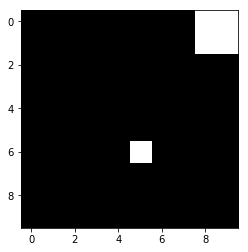

In [123]:
debug = False


# net_1 = Net(2, 2)
# net_2 = Net(2, 2)
# history = [5]

# print (net_1.eval([1, 2]))

# net_1.add_node(history)
# net_1.add_connection(history)

# net_3 = crossover(net_1, net_2)

# print (net_1.eval([1, 2]))
# print (net_2.eval([1, 2]))
# print (net_3.eval([1, 2]))

trainer = Trainer(20, 24, 3)

snake = Snake(grid_size = 10)
trainer.train(10, snake)

animation = trainer.replay_best(snake)
IPython.display.HTML(animation.to_jshtml())

In [24]:
a = [1, 2, 3, 4]
a[:-1]

[1, 2, 3]